In [1]:
# CARREGAR BIBLIOTECAS

# Use the os package to interact with the environment
import os
import sys

# Bring in Pandas for Dataframe functionality
import pandas as pd
from functools import reduce

# Bring some visualization functionality 
import seaborn as sns

# numpy for basics
import numpy as np

# Use StringIO for working with file contents
from io import StringIO

# Enable IPython to display matplotlib graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Enable interaction with the FireCloud API
from firecloud import api as fapi

# Import the iPython HTML rendering for displaying links to Google Cloud Console
from IPython.display import display, HTML

# Import urllib modules for building URLs to Google Cloud Console
import urllib.parse

# BigQuery for querying data
from google.cloud import bigquery

In [2]:
# FUNÇÕES ÚTEIS

# Utility routine for printing a shell command before executing it
def shell_do(command):
    print(f'Executing: {command}', file=sys.stderr)
    !$command
    
def shell_return(command):
    print(f'Executing: {command}', file=sys.stderr)
    output = !$command
    return '\n'.join(output)

# Utility routine for printing a query before executing it
def bq_query(query):
    print(f'Executing: {query}', file=sys.stderr)
    return pd.read_gbq(query, project_id=BILLING_PROJECT_ID, dialect='standard')

# Utility routine for display a message and a link
def display_html_link(description, link_text, url):
    html = f'''
    <p>
    </p>
    <p>
    {description}
    <a target=_blank href="{url}">{link_text}</a>.
    </p>
    '''

    display(HTML(html))

# Utility routines for reading files from Google Cloud Storage
def gcs_read_file(path):
    """Return the contents of a file in GCS"""
    contents = !gsutil -u {BILLING_PROJECT_ID} cat {path}
    return '\n'.join(contents)
    
def gcs_read_csv(path, sep=None):
    """Return a DataFrame from the contents of a delimited file in GCS"""
    return pd.read_csv(StringIO(gcs_read_file(path)), sep=sep, engine='python')

# Utility routine for displaying a message and link to Cloud Console
def link_to_cloud_console_gcs(description, link_text, gcs_path):
    url = '{}?{}'.format(
        os.path.join('https://console.cloud.google.com/storage/browser',
                     gcs_path.replace("gs://","")),
        urllib.parse.urlencode({'userProject': BILLING_PROJECT_ID}))

    display_html_link(description, link_text, url)

In [3]:
# CAMINHOS E VARIÁVEIS

# Set up billing project and data path variables
BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
WORKSPACE_NAMESPACE = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE_NAME = os.environ['WORKSPACE_NAME']
WORKSPACE_BUCKET = os.environ['WORKSPACE_BUCKET']

WORKSPACE_ATTRIBUTES = fapi.get_workspace(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json().get('workspace',{}).get('attributes',{})

## Print the information to check we are in the proper release and billing 
## This will be different for you, the user, depending on the billing project your workspace is on
print('Billing and Workspace')
print(f'Workspace Name: {WORKSPACE_NAME}')
print(f'Billing Project: {BILLING_PROJECT_ID}')
print(f'Workspace Bucket, where you can upload and download data: {WORKSPACE_BUCKET}')
print('')

## AMP-PD v2.5
## Explicitly define release v2.5 path 
AMP_RELEASE_PATH = 'gs://amp-pd-data/releases/2023_v4release_1027'
AMP_CLINICAL_RELEASE_PATH = f'{AMP_RELEASE_PATH}/clinical'

AMP_WGS_RELEASE_PATH = 'gs://amp-pd-genomics/releases/2023_v4release_1027' 

AMP_WGS_SAMPLES_PATH = 'gs://amp-pd-genomics/samples'
AMP_WGS_SAMPLES_PATH_WGS = 'gs://amp-pd-genomics/samples/wgs'
AMP_WGS_SAMPLES_GATK_PATH = os.path.join(AMP_WGS_SAMPLES_PATH, 'gatk')
AMP_WGS_RELEASE_PATH_ = 'gs://amp-pd-genomics/samples/wgs/gatk'
AMP_WGS_RELEASE_GATK_PATH = os.path.join(AMP_WGS_RELEASE_PATH, 'gatk')
AMP_WGS_RELEASE_PLINK_PATH = os.path.join(AMP_WGS_RELEASE_PATH, 'plink')
BQ_WGS_RELEASE_DATASET = 'bq_ds_amp_pd_genomics_wgs_release'
BQ_WGS_RELEASE_DATASET_STD = BQ_WGS_RELEASE_DATASET.replace(':', '.')


## Print the information to check we are in the proper release and billing 
## This will be different for you, the user, depending on the billing project your workspace is on
print('Billing and Workspace')
print(f'Workspace Name: {WORKSPACE_NAME}')
print(f'Billing Project: {BILLING_PROJECT_ID}')
print(f'Workspace Bucket, where you can upload and download data: {WORKSPACE_BUCKET}')
print('')

print('AMP-PD v4.0')
print(f'Path to AMP-PD v4.0 Clinical Data: {AMP_CLINICAL_RELEASE_PATH}')
print(f'Path to AMP-PD v4.0 WGS Data: {AMP_WGS_RELEASE_PLINK_PATH}')
print('')

Billing and Workspace
Workspace Name: NOS1 - dyskinesia
Billing Project: terra-d22fb823
Workspace Bucket, where you can upload and download data: gs://fc-secure-5dd0ff90-839e-485e-9021-a5a7ad3060ec

Billing and Workspace
Workspace Name: NOS1 - dyskinesia
Billing Project: terra-d22fb823
Workspace Bucket, where you can upload and download data: gs://fc-secure-5dd0ff90-839e-485e-9021-a5a7ad3060ec

AMP-PD v4.0
Path to AMP-PD v4.0 Clinical Data: gs://amp-pd-data/releases/2023_v4release_1027/clinical
Path to AMP-PD v4.0 WGS Data: gs://amp-pd-genomics/releases/2023_v4release_1027/plink



In [4]:
# Create a folder on your workspace to copy to 
print("Making a working directory")
WORK_DIR = f'data'
shell_do(f'mkdir -p {WORK_DIR}')


Making a working directory


Executing: mkdir -p data


In [5]:
# Check directory where AMPPD Tier 2 data is
print("List of available genomic data in AMP-PD")
shell_do(f'gsutil -u {BILLING_PROJECT_ID} ls {AMP_CLINICAL_RELEASE_PATH}')


List of available genomic data in AMP-PD


Executing: gsutil -u terra-d22fb823 ls gs://amp-pd-data/releases/2023_v4release_1027/clinical


gs://amp-pd-data/releases/2023_v4release_1027/clinical/Biospecimen_analyses_CSF_abeta_tau_ptau.csv
gs://amp-pd-data/releases/2023_v4release_1027/clinical/Biospecimen_analyses_CSF_abeta_tau_ptau_dictionary.csv
gs://amp-pd-data/releases/2023_v4release_1027/clinical/Biospecimen_analyses_CSF_beta_glucocerebrosidase.csv
gs://amp-pd-data/releases/2023_v4release_1027/clinical/Biospecimen_analyses_CSF_beta_glucocerebrosidase_dictionary.csv
gs://amp-pd-data/releases/2023_v4release_1027/clinical/Biospecimen_analyses_SomaLogic_plasma.csv
gs://amp-pd-data/releases/2023_v4release_1027/clinical/Biospecimen_analyses_SomaLogic_plasma_dictionary.csv
gs://amp-pd-data/releases/2023_v4release_1027/clinical/Biospecimen_analyses_other.csv
gs://amp-pd-data/releases/2023_v4release_1027/clinical/Biospecimen_analyses_other_dictionary.csv
gs://amp-pd-data/releases/2023_v4release_1027/clinical/Caffeine_history.csv
gs://amp-pd-data/releases/2023_v4release_1027/clinical/Caffeine_history_dictionary.csv
gs://amp-pd-d

In [6]:
#Importar arquivos CAFEÍNA, ALCOOL E CIGARRO

shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r gs://amp-pd-data/releases/2023_v4release_1027/clinical/Caffeine_history.csv {WORK_DIR}')
#shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r gs://amp-pd-data/releases/2023_v4release_1027/clinical/Caffeine_history_dictionary.csv {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r gs://amp-pd-data/releases/2023_v4release_1027/clinical/Smoking_and_alcohol_history.csv {WORK_DIR}')
#shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r gs://amp-pd-data/releases/2023_v4release_1027/clinical/Smoking_and_alcohol_history_dictionary.csv {WORK_DIR}')


Executing: gsutil -u terra-d22fb823 -m cp -r gs://amp-pd-data/releases/2023_v4release_1027/clinical/Caffeine_history.csv data


Copying gs://amp-pd-data/releases/2023_v4release_1027/clinical/Caffeine_history.csv...
/ [1/1 files][ 74.5 KiB/ 74.5 KiB] 100% Done                                    
Operation completed over 1 objects/74.5 KiB.                                     


Executing: gsutil -u terra-d22fb823 -m cp -r gs://amp-pd-data/releases/2023_v4release_1027/clinical/Smoking_and_alcohol_history.csv data


Copying gs://amp-pd-data/releases/2023_v4release_1027/clinical/Smoking_and_alcohol_history.csv...
/ [1/1 files][387.6 KiB/387.6 KiB] 100% Done                                    
Operation completed over 1 objects/387.6 KiB.                                    


In [7]:
#Importar arquivos de respostas UPDRS

shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r gs://amp-pd-data/releases/2023_v4release_1027/clinical/MDS_UPDRS_Part_III.csv  {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r gs://amp-pd-data/releases/2023_v4release_1027/clinical/MDS_UPDRS_Part_IV.csv  {WORK_DIR}')
#shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r gs://amp-pd-data/releases/2023_v4release_1027/clinical/MDS_UPDRS_Part_IV_dictionary.csv  {WORK_DIR}')
#shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r gs://amp-pd-data/releases/2023_v4release_1027/clinical/MDS_UPDRS_Part_III_dictionary.csv  {WORK_DIR}')

Executing: gsutil -u terra-d22fb823 -m cp -r gs://amp-pd-data/releases/2023_v4release_1027/clinical/MDS_UPDRS_Part_III.csv  data


Copying gs://amp-pd-data/releases/2023_v4release_1027/clinical/MDS_UPDRS_Part_III.csv...
/ [1/1 files][  7.5 MiB/  7.5 MiB] 100% Done                                    
Operation completed over 1 objects/7.5 MiB.                                      


Executing: gsutil -u terra-d22fb823 -m cp -r gs://amp-pd-data/releases/2023_v4release_1027/clinical/MDS_UPDRS_Part_IV.csv  data


Copying gs://amp-pd-data/releases/2023_v4release_1027/clinical/MDS_UPDRS_Part_IV.csv...
/ [1/1 files][990.4 KiB/990.4 KiB] 100% Done                                    
Operation completed over 1 objects/990.4 KiB.                                    


In [8]:
#Importar arquivos de dados clínicos

shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {AMP_CLINICAL_RELEASE_PATH}/Demographics.csv {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {AMP_RELEASE_PATH}/amp_pd_case_control.csv {WORK_DIR}')


Executing: gsutil -u terra-d22fb823 -m cp -r gs://amp-pd-data/releases/2023_v4release_1027/clinical/Demographics.csv data


Copying gs://amp-pd-data/releases/2023_v4release_1027/clinical/Demographics.csv...
/ [1/1 files][628.5 KiB/628.5 KiB] 100% Done                                    
Operation completed over 1 objects/628.5 KiB.                                    


Executing: gsutil -u terra-d22fb823 -m cp -r gs://amp-pd-data/releases/2023_v4release_1027/amp_pd_case_control.csv data


Copying gs://amp-pd-data/releases/2023_v4release_1027/amp_pd_case_control.csv...
/ [1/1 files][742.4 KiB/742.4 KiB] 100% Done                                    
Operation completed over 1 objects/742.4 KiB.                                    


In [9]:
!ls data

amp_pd_case_control.csv		    MDS_UPDRS_Part_III.csv
AMP-PD_CASOS_SEM_DUPLICADAS.csv     MDS_UPDRS_Part_III_dictionary.csv
AMP-PD_CONTROLE_SEM_DUPLICADAS.csv  MDS_UPDRS_Part_IV.csv
Caffeine_history.csv		    MDS_UPDRS_Part_IV_dictionary.csv
Caffeine_history_dictionary.csv     Smoking_and_alcohol_history.csv
Demographics.csv		    Smoking_and_alcohol_history_dictionary.csv


In [10]:

# Definir para exibir todas as linhas
#pd.set_option('display.max_rows', None)

# Definir para exibir todas as colunas
#pd.set_option('display.max_columns', None)

# RESETAR
pd.reset_option('display.max_rows')



In [11]:
# Transformar os arquivos em DataFrames

UPDRS_3 = pd.read_csv(f'{WORK_DIR}/MDS_UPDRS_Part_III.csv')
UPDRS_4 = pd.read_csv(f'{WORK_DIR}/MDS_UPDRS_Part_IV.csv')

cafe = pd.read_csv(f'{WORK_DIR}/Caffeine_history.csv')
cafe_dic = pd.read_csv(f'{WORK_DIR}/Caffeine_history_dictionary.csv')
alcool_cigarro = pd.read_csv(f'{WORK_DIR}/Smoking_and_alcohol_history.csv')
alcool_cigarro_dic = pd.read_csv(f'{WORK_DIR}/Smoking_and_alcohol_history_dictionary.csv')

casos = pd.read_csv(f'{WORK_DIR}/AMP-PD_CASOS_SEM_DUPLICADAS.csv')
controles = pd.read_csv(f'{WORK_DIR}/AMP-PD_CONTROLE_SEM_DUPLICADAS.csv')
amp_pd_demo = pd.read_csv(f'{WORK_DIR}/Demographics.csv')
amp_pd_case_control = pd.read_csv(f'{WORK_DIR}/amp_pd_case_control.csv')



In [12]:
#Limpar DataFrames

UPDRS_3_sum = UPDRS_3[['participant_id', 'GUID', 'visit_name', 'mds_updrs_part_iii_summary_score']]
UPDRS_3_sum = UPDRS_3_sum.drop_duplicates(subset='participant_id')

In [13]:
UPDRS_3_sum

,participant_id,GUID,visit_name,mds_updrs_part_iii_summary_score
0,BF-1001,PDNW781VHY,M0,0.0
1,BF-1002,PDCB969UGG,M0,15.0
3,BF-1003,PDLW805AHT,M0,12.0
5,BF-1004,PDKW284DYW,M0,33.0
7,BF-1005,PDTM274KX6,M0,0.0
...,...,...,...,...
23548,PM-UD_11327_001,NaN,SC#1,NaN
23550,PM-UD_40301_001,NaN,SC#1,NaN
23551,PM-UD_11353_001,NaN,SC#1,NaN
23553,PM-UD_1052_001,NaN,SC#1,NaN


In [14]:
#Limpar DataFrames

UPDRS_4_sum = UPDRS_4[['participant_id', 'GUID', 'visit_name', 'code_upd2401_time_spent_with_dyskinesias', 'code_upd2402_functional_impact_of_dyskinesias', 'mds_updrs_part_iv_summary_score']]
UPDRS_4_sum = UPDRS_4_sum.drop_duplicates(subset='participant_id')

In [15]:
UPDRS_4_sum

,participant_id,GUID,visit_name,code_upd2401_time_spent_with_dyskinesias,code_upd2402_functional_impact_of_dyskinesias,mds_updrs_part_iv_summary_score
0,BF-1002,PDCB969UGG,M0,0.0,0.0,9.0
1,BF-1003,PDLW805AHT,M0,0.0,0.0,4.0
2,BF-1004,PDKW284DYW,M0,1.0,1.0,6.0
3,BF-1006,PDKY484YDC,M0,0.0,0.0,0.0
4,BF-1008,PDEA056CRM,M0,0.0,0.0,6.0
...,...,...,...,...,...,...
13076,PP-73614,NaN,M18,0.0,0.0,0.0
13077,PP-74199,NIHTL909XRKAZ,M0,0.0,0.0,8.0
13080,PP-41299,NaN,M0,3.0,0.0,10.0
13082,PM-UD_11659_001,NaN,SC#1,NaN,NaN,0.0


In [16]:
# Concatenar os DataFrames - CAFEZINHO

cafe_UPDRS_3 = pd.merge(cafe, UPDRS_3_sum, on = 'participant_id')
cafe_UPDRS_sum = pd.merge(cafe_UPDRS_3, UPDRS_4_sum, on = 'participant_id')

cafe_UPDRS_sum


,participant_id,GUID_x,visit_name_x,visit_month,caff_drinks_ever_used_regularly,caff_drinks_current_use,GUID_y,visit_name_y,mds_updrs_part_iii_summary_score,GUID,visit_name,code_upd2401_time_spent_with_dyskinesias,code_upd2402_functional_impact_of_dyskinesias,mds_updrs_part_iv_summary_score
0,HB-PD_INVAA223GY7,PD_INVAA223GY7,M0,0.0,No,No,PD_INVAA223GY7,M0,NaN,PD_INVAA223GY7,M0,0.0,NaN,NaN
1,HB-PD_INVAD802MY3,PD_INVAD802MY3,M0,0.0,No,No,PD_INVAD802MY3,M0,NaN,PD_INVAD802MY3,M0,0.0,NaN,NaN
2,HB-PD_INVAE641BA6,PD_INVAE641BA6,M0,0.0,No,No,PD_INVAE641BA6,M0,NaN,PD_INVAE641BA6,M0,0.0,NaN,NaN
3,HB-PD_INVAF026XUY,PD_INVAF026XUY,M0,0.0,Yes,Yes,PD_INVAF026XUY,M0,NaN,PD_INVAF026XUY,M0,0.0,NaN,NaN
4,HB-PD_INVAF194FCZ,PD_INVAF194FCZ,M0,0.0,Yes,Yes,PD_INVAF194FCZ,M0,NaN,PD_INVAF194FCZ,M0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,PP-90456,NaN,LOG,NaN,No,No,NaN,M0,9.0,NaN,M36,0.0,0.0,0.0
967,PP-92834,NaN,LOG,NaN,Yes,Yes,NaN,M0,0.0,NaN,M18,0.0,0.0,0.0
968,PP-70188,NIHDR666KXJER,LOG,NaN,Yes,No,NIHDR666KXJER,M18,20.0,NIHDR666KXJER,M0,0.0,0.0,1.0
969,PP-74199,NIHTL909XRKAZ,LOG,NaN,Yes,No,NIHTL909XRKAZ,M12,24.0,NIHTL909XRKAZ,M0,0.0,0.0,8.0


In [17]:
# Concatenar os DataFrames - CIGARRINHO E BREJINHA

alcool_cigarro_UPDRS_3 = pd.merge(alcool_cigarro, UPDRS_3_sum, on = 'participant_id')
alcool_cigarro_UPDRS_sum = pd.merge(alcool_cigarro_UPDRS_3, UPDRS_4_sum, on = 'participant_id')

alcool_cigarro_UPDRS_sum


,participant_id,GUID_x,visit_name_x,visit_month,tobacco_ever_used,tobacco_current_use,smoked_100_more_cigarettes,alcohol_ever_used,alcohol_current_use,tobacco_recent_use,...,alcohol_consumption_change,alcohol_inc_dec,GUID_y,visit_name_y,mds_updrs_part_iii_summary_score,GUID,visit_name,code_upd2401_time_spent_with_dyskinesias,code_upd2402_functional_impact_of_dyskinesias,mds_updrs_part_iv_summary_score
0,BF-1085,PDKH960RVF,M0,0.0,Yes,No,Yes,Yes,Yes,NaN,...,NaN,NaN,PDKH960RVF,M0,14.0,PDKH960RVF,M0,0.0,0.0,2.0
1,BF-1121,PDFK952LNH,M0,0.0,Yes,No,Yes,Yes,No,NaN,...,NaN,NaN,PDFK952LNH,M0,24.0,PDFK952LNH,M0,0.0,0.0,4.0
2,BF-1123,PDPW971YLK,M0,0.0,Unknown,NaN,No,Yes,No,NaN,...,NaN,NaN,PDPW971YLK,M0,53.0,PDPW971YLK,M0,1.0,0.0,7.0
3,BF-1124,PDFJ573KXY,M0,0.0,Yes,No,Yes,Yes,Yes,NaN,...,NaN,NaN,PDFJ573KXY,M0,44.0,PDFJ573KXY,M0,1.0,1.0,9.0
4,BF-1125,PDGM095LTR,M0,0.0,Unknown,NaN,No,No,NaN,NaN,...,NaN,NaN,PDGM095LTR,M0,47.0,PDGM095LTR,M0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2598,SU-33542,PDNV588FMK,M0,0.0,No,No,NaN,Yes,Yes,No,...,NaN,NaN,PDNV588FMK,M0,19.0,PDNV588FMK,M0,NaN,NaN,NaN
2599,PP-70188,NIHDR666KXJER,LOG,NaN,Unknown,No,NaN,Yes,NaN,NaN,...,NaN,NaN,NIHDR666KXJER,M18,20.0,NIHDR666KXJER,M0,0.0,0.0,1.0
2600,PP-74199,NIHTL909XRKAZ,LOG,NaN,Yes,No,Yes,Yes,Yes,NaN,...,NaN,NaN,NIHTL909XRKAZ,M12,24.0,NIHTL909XRKAZ,M0,0.0,0.0,8.0
2601,PM-UD_11659_001,NaN,SC#1,-120.0,Yes,NaN,NaN,Yes,NaN,NaN,...,NaN,NaN,NaN,SC#1,NaN,NaN,SC#1,NaN,NaN,0.0


In [18]:
#Limpar DataFrames, manter apenas colunas necessárias

cafezin = cafe_UPDRS_sum[['participant_id', 'visit_name', 'caff_drinks_ever_used_regularly', 'caff_drinks_current_use', 'mds_updrs_part_iii_summary_score', 'mds_updrs_part_iv_summary_score']]
cigarrin = alcool_cigarro_UPDRS_sum[['participant_id', 'visit_name', 'tobacco_ever_used', 'tobacco_current_use', 'smoked_100_more_cigarettes', 'mds_updrs_part_iii_summary_score', 'mds_updrs_part_iv_summary_score']]
brejinha = alcool_cigarro_UPDRS_sum[['participant_id', 'visit_name', 'alcohol_ever_used', 'alcohol_current_use', 'mds_updrs_part_iii_summary_score', 'mds_updrs_part_iv_summary_score' ]]


In [19]:

cafezin


,participant_id,visit_name,caff_drinks_ever_used_regularly,caff_drinks_current_use,mds_updrs_part_iii_summary_score,mds_updrs_part_iv_summary_score
0,HB-PD_INVAA223GY7,M0,No,No,NaN,NaN
1,HB-PD_INVAD802MY3,M0,No,No,NaN,NaN
2,HB-PD_INVAE641BA6,M0,No,No,NaN,NaN
3,HB-PD_INVAF026XUY,M0,Yes,Yes,NaN,NaN
4,HB-PD_INVAF194FCZ,M0,Yes,Yes,NaN,NaN
...,...,...,...,...,...,...
966,PP-90456,M36,No,No,9.0,0.0
967,PP-92834,M18,Yes,Yes,0.0,0.0
968,PP-70188,M0,Yes,No,20.0,1.0
969,PP-74199,M0,Yes,No,24.0,8.0


In [20]:

cigarrin


,participant_id,visit_name,tobacco_ever_used,tobacco_current_use,smoked_100_more_cigarettes,mds_updrs_part_iii_summary_score,mds_updrs_part_iv_summary_score
0,BF-1085,M0,Yes,No,Yes,14.0,2.0
1,BF-1121,M0,Yes,No,Yes,24.0,4.0
2,BF-1123,M0,Unknown,NaN,No,53.0,7.0
3,BF-1124,M0,Yes,No,Yes,44.0,9.0
4,BF-1125,M0,Unknown,NaN,No,47.0,5.0
...,...,...,...,...,...,...,...
2598,SU-33542,M0,No,No,NaN,19.0,NaN
2599,PP-70188,M0,Unknown,No,NaN,20.0,1.0
2600,PP-74199,M0,Yes,No,Yes,24.0,8.0
2601,PM-UD_11659_001,SC#1,Yes,NaN,NaN,NaN,0.0


In [21]:

brejinha


,participant_id,visit_name,alcohol_ever_used,alcohol_current_use,mds_updrs_part_iii_summary_score,mds_updrs_part_iv_summary_score
0,BF-1085,M0,Yes,Yes,14.0,2.0
1,BF-1121,M0,Yes,No,24.0,4.0
2,BF-1123,M0,Yes,No,53.0,7.0
3,BF-1124,M0,Yes,Yes,44.0,9.0
4,BF-1125,M0,No,NaN,47.0,5.0
...,...,...,...,...,...,...
2598,SU-33542,M0,Yes,Yes,19.0,NaN
2599,PP-70188,M0,Yes,NaN,20.0,1.0
2600,PP-74199,M0,Yes,Yes,24.0,8.0
2601,PM-UD_11659_001,SC#1,Yes,NaN,NaN,0.0


In [22]:
#Excluir dados faltantes

cafezin_final = cafezin.dropna(subset=['caff_drinks_ever_used_regularly', 'caff_drinks_current_use', 'mds_updrs_part_iii_summary_score', 'mds_updrs_part_iv_summary_score'])
cigarrin_final = cigarrin.dropna(subset=['tobacco_ever_used', 'tobacco_current_use', 'mds_updrs_part_iii_summary_score', 'mds_updrs_part_iv_summary_score'])
brejinha_final = brejinha.dropna(subset=['alcohol_ever_used', 'alcohol_current_use', 'mds_updrs_part_iii_summary_score', 'mds_updrs_part_iv_summary_score'])


In [23]:

print(f"{'Cafezin final'}: {cafezin_final.shape}")
print(f"{'Cigarrin final'}: {cigarrin_final.shape}")
print(f"{'Brejinha final'}: {brejinha_final.shape}")


Cafezin final: (339, 6)
Cigarrin final: (1029, 7)
Brejinha final: (1235, 6)


In [24]:
cigarrin_final

,participant_id,visit_name,tobacco_ever_used,tobacco_current_use,smoked_100_more_cigarettes,mds_updrs_part_iii_summary_score,mds_updrs_part_iv_summary_score
0,BF-1085,M0,Yes,No,Yes,14.0,2.0
1,BF-1121,M0,Yes,No,Yes,24.0,4.0
3,BF-1124,M0,Yes,No,Yes,44.0,9.0
5,BF-1133,M0,Yes,No,Yes,33.0,4.0
8,BF-1140,M0,Yes,No,Yes,29.0,2.0
...,...,...,...,...,...,...,...
2521,SU-32881,M0,No,No,NaN,19.0,0.0
2555,SU-33182,M0,Yes,No,NaN,18.0,0.0
2599,PP-70188,M0,Unknown,No,NaN,20.0,1.0
2600,PP-74199,M0,Yes,No,Yes,24.0,8.0


In [25]:
# TESTAR NORMALIDADE COM PINGOUIN

!pip install pingouin

import pingouin as pg


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [26]:
# Normalidade cafe

print(pg.normality(cafezin_final)) 


                                         W          pval  normal
mds_updrs_part_iii_summary_score  0.962335  1.149881e-07   False
mds_updrs_part_iv_summary_score   0.583039  9.976221e-28   False


In [27]:
# Normalidade cigarro

print(pg.normality(cigarrin_final)) 


                                         W          pval  normal
mds_updrs_part_iii_summary_score  0.920261  6.995196e-23   False
mds_updrs_part_iv_summary_score   0.575682  2.242078e-44   False


In [28]:
# Normalidade cerveja

print(pg.normality(brejinha_final)) 


                                         W          pval  normal
mds_updrs_part_iii_summary_score  0.902263  2.297231e-27   False
mds_updrs_part_iv_summary_score   0.563585  0.000000e+00   False


In [29]:
## TRANSFORMAR RESPOSTAS YES E NO

cafe_binario = cafezin_final.copy()
cigarro_binario = cigarrin_final.copy()
cerveja_binario = brejinha_final.copy()

# Transformar

colunas_cafe = ['caff_drinks_ever_used_regularly', 'caff_drinks_current_use']
cafe_binario[colunas_cafe] = cafe_binario[colunas_cafe].replace({'Yes': 1, 'No': 0})

colunas_cigarro = ['tobacco_ever_used', 'tobacco_current_use']
cigarro_binario[colunas_cigarro] = cigarro_binario[colunas_cigarro].replace({'Yes': 1, 'No': 0})

colunas_cerveja = ['alcohol_ever_used', 'alcohol_current_use'] 
cerveja_binario[colunas_cerveja] = cerveja_binario[colunas_cerveja].replace({'Yes': 1, 'No': 0})



In [30]:
cigarro_binario

,participant_id,visit_name,tobacco_ever_used,tobacco_current_use,smoked_100_more_cigarettes,mds_updrs_part_iii_summary_score,mds_updrs_part_iv_summary_score
0,BF-1085,M0,1,0,Yes,14.0,2.0
1,BF-1121,M0,1,0,Yes,24.0,4.0
3,BF-1124,M0,1,0,Yes,44.0,9.0
5,BF-1133,M0,1,0,Yes,33.0,4.0
8,BF-1140,M0,1,0,Yes,29.0,2.0
...,...,...,...,...,...,...,...
2521,SU-32881,M0,0,0,NaN,19.0,0.0
2555,SU-33182,M0,1,0,NaN,18.0,0.0
2599,PP-70188,M0,Unknown,0,NaN,20.0,1.0
2600,PP-74199,M0,1,0,Yes,24.0,8.0


In [31]:
# Filtra os dados para cada grupo

# CAFE

cafe_sim = cafe_binario[cafe_binario['caff_drinks_ever_used_regularly'] == 1]
cafe_nao = cafe_binario[cafe_binario['caff_drinks_ever_used_regularly'] == 0]

# CIGARRO

cigarro_sim = cigarro_binario[cigarro_binario['tobacco_ever_used'] == 1]
cigarro_nao = cigarro_binario[cigarro_binario['tobacco_ever_used'] == 0]

# CERVEJA

cerveja_sim = cerveja_binario[cerveja_binario['alcohol_current_use'] == 1]
cerveja_nao = cerveja_binario[cerveja_binario['alcohol_current_use'] == 0]

cigarro_sim.shape


(664, 7)

In [32]:
cigarro_nao

,participant_id,visit_name,tobacco_ever_used,tobacco_current_use,smoked_100_more_cigarettes,mds_updrs_part_iii_summary_score,mds_updrs_part_iv_summary_score
658,PD-PDAA503EF5,M0,0,0,NaN,20.0,0.0
661,PD-PDAB411CTU,M0,0,0,NaN,0.0,0.0
662,PD-PDAB549YWB,M0,0,0,NaN,5.0,4.0
677,PD-PDAG669PAY,M0,0,0,NaN,9.0,0.0
685,PD-PDAK348WWH,M0,0,0,NaN,25.0,2.0
...,...,...,...,...,...,...,...
2041,PD-PDZU117PHT,M0,0,0,NaN,0.0,0.0
2056,PD-PDZZ133PFJ,M0,0,0,NaN,15.0,20.0
2057,PD-PDZZ298XEH,M0,0,0,NaN,21.0,6.0
2466,SU-32649,M0,0,0,NaN,15.0,0.0


In [33]:
## TESTE DE MANN WITHNEY U

cafe_sim_III = cafe_sim['mds_updrs_part_iii_summary_score']
cafe_nao_III = cafe_nao['mds_updrs_part_iii_summary_score']

cafe_sim_IV = cafe_sim['mds_updrs_part_iv_summary_score']
cafe_nao_IV = cafe_nao['mds_updrs_part_iv_summary_score']

#--------------------------------------------------------------------#

cigarro_sim_III = cigarro_sim['mds_updrs_part_iii_summary_score']
cigarro_nao_III = cigarro_nao['mds_updrs_part_iii_summary_score']

cigarro_sim_IV = cigarro_sim['mds_updrs_part_iv_summary_score']
cigarro_nao_IV = cigarro_nao['mds_updrs_part_iv_summary_score']

#--------------------------------------------------------------------#

cerveja_sim_III = cerveja_sim['mds_updrs_part_iii_summary_score']
cerveja_nao_III = cerveja_nao['mds_updrs_part_iii_summary_score']

cerveja_sim_IV = cerveja_sim['mds_updrs_part_iv_summary_score']
cerveja_nao_IV = cerveja_nao['mds_updrs_part_iv_summary_score']


In [34]:
Teste_cafe_III = pg.mwu(cafe_sim_III, cafe_nao_III)

print('CAFE III')
print(Teste_cafe_III)

CAFE III
      U-val alternative     p-val       RBC      CLES
MWU  5913.5   two-sided  0.004909  0.315573  0.657786


In [35]:
Teste_cafe_IV = pg.mwu(cafe_sim_IV, cafe_nao_IV)

print('CAFE IV')
print(Teste_cafe_IV)

CAFE IV
      U-val alternative     p-val       RBC      CLES
MWU  4652.0   two-sided  0.698383  0.034928  0.517464


In [36]:
Teste_cigarro_III = pg.mwu(cigarro_sim_III, cigarro_nao_III)

print('Cigarro III')
print(Teste_cigarro_III)

Cigarro III
       U-val alternative     p-val       RBC      CLES
MWU  61513.0   two-sided  0.526677 -0.029947  0.485026


In [37]:
Teste_cigarro_IV = pg.mwu(cigarro_sim_IV, cigarro_nao_IV)

print('Cigarro IV')
print(Teste_cigarro_IV)

Cigarro IV
       U-val alternative     p-val       RBC     CLES
MWU  62284.5   two-sided  0.647382 -0.017781  0.49111


In [38]:
Teste_cerveja_III = pg.mwu(cerveja_sim_III, cerveja_nao_III)

print('Cerveja III')
print(Teste_cerveja_III)

Cerveja III
        U-val alternative     p-val       RBC      CLES
MWU  104607.0   two-sided  0.000097 -0.157652  0.421174


In [39]:
Teste_cerveja_IV = pg.mwu(cerveja_sim_IV, cerveja_nao_IV)

print('Cerveja IV')
print(Teste_cerveja_IV)

Cerveja IV
        U-val alternative     p-val      RBC     CLES
MWU  120824.5   two-sided  0.403823 -0.02706  0.48647



TESTES QUE APRESENTARAM DIFERENÇA ESTATÍSTICA:

CAFE III  // p-valor = 0,049

CERVEJA III // p-valor = 0,000097

In [40]:
## Regressão linear cafe

X1 = cafe_binario['caff_drinks_ever_used_regularly']
Y1 = cafe_binario['mds_updrs_part_iii_summary_score']

reg_cafe = pg.linear_regression(X1,Y1)

print(reg_cafe)

                             names       coef        se         T  \
0                        Intercept  13.241379  2.447799  5.409504   
1  caff_drinks_ever_used_regularly   6.568298  2.559734  2.566009   

           pval        r2    adj_r2  CI[2.5%]  CI[97.5%]  
0  1.200679e-07  0.019164  0.016253  8.426489  18.056269  
1  1.071942e-02  0.019164  0.016253  1.533230  11.603366  


In [41]:
# Regressão linear cerveja

cerveja_binario['alcohol_current_use'] = pd.to_numeric(cerveja_binario['alcohol_current_use'], errors='coerce')
cerveja_binario = cerveja_binario[cerveja_binario['alcohol_current_use'].isin([0, 1])& cerveja_binario['mds_updrs_part_iii_summary_score'].notna()]

X2 = cerveja_binario['alcohol_current_use']
Y2 = cerveja_binario['mds_updrs_part_iii_summary_score']

reg_cerveja = pg.linear_regression(X2,Y2)

print(reg_cerveja)

                 names       coef        se          T          pval  \
0            Intercept  21.721569  1.024262  21.207041  2.747055e-85   
1  alcohol_current_use  -4.830398  1.150556  -4.198318  2.883135e-05   

         r2    adj_r2   CI[2.5%]  CI[97.5%]  
0  0.014162  0.013358  19.712070  23.731068  
1  0.014162  0.013358  -7.087672  -2.573124  


---------------------------------------------------------------------------------------------------
###### GRÁFICOS CAFÉ #####

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns


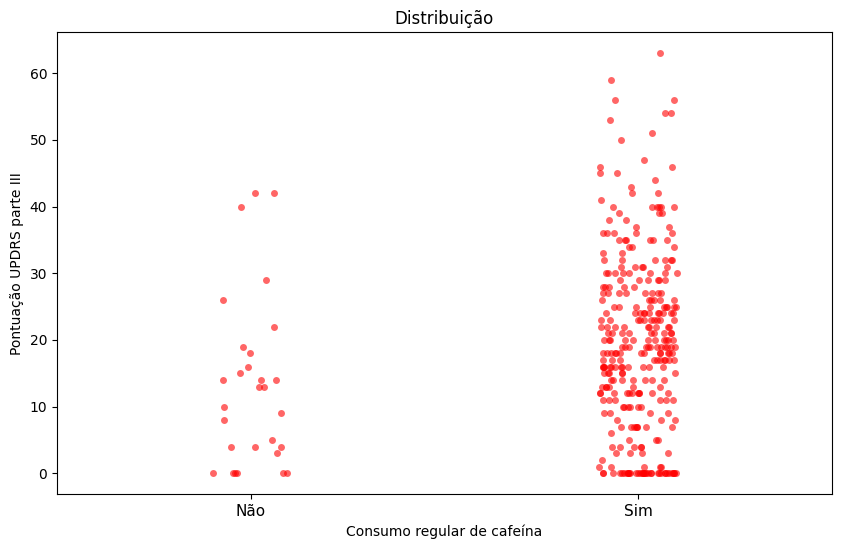

In [43]:
# Gráfico de distribuição

plt.figure(figsize=(10, 6))
sns.stripplot(x='caff_drinks_ever_used_regularly', y='mds_updrs_part_iii_summary_score', data=cafe_binario, jitter=True, alpha=0.6, color='red')

plt.xticks([0, 1], ['Não', 'Sim'], fontsize=11)
plt.xlabel("Consumo regular de cafeína")
plt.ylabel("Pontuação UPDRS parte III")
plt.title("Distribuição")
plt.show()

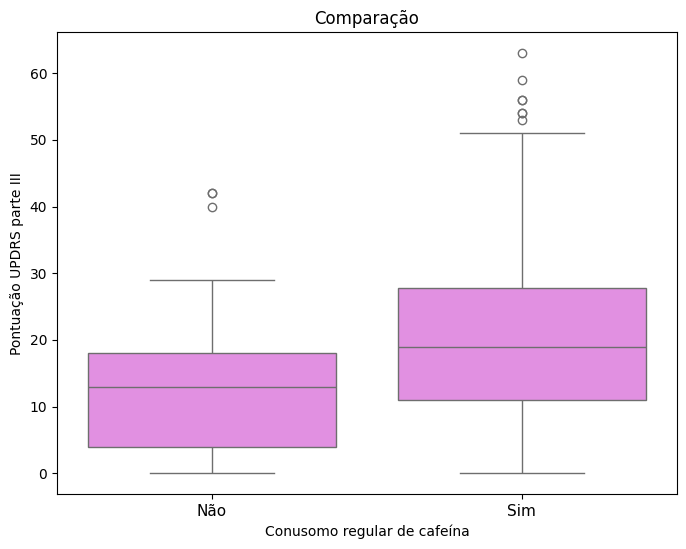

In [44]:
# Boxplot 
plt.figure(figsize=(8, 6))
sns.boxplot(x='caff_drinks_ever_used_regularly', y='mds_updrs_part_iii_summary_score', data=cafe_binario, color = 'violet')

plt.xticks([0, 1], ['Não', 'Sim'], fontsize=11)
plt.xlabel("Conusomo regular de cafeína")
plt.ylabel("Pontuação UPDRS parte III")
plt.title("Comparação")
plt.show()

/tmp/ipykernel_74/1215770727.py:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(


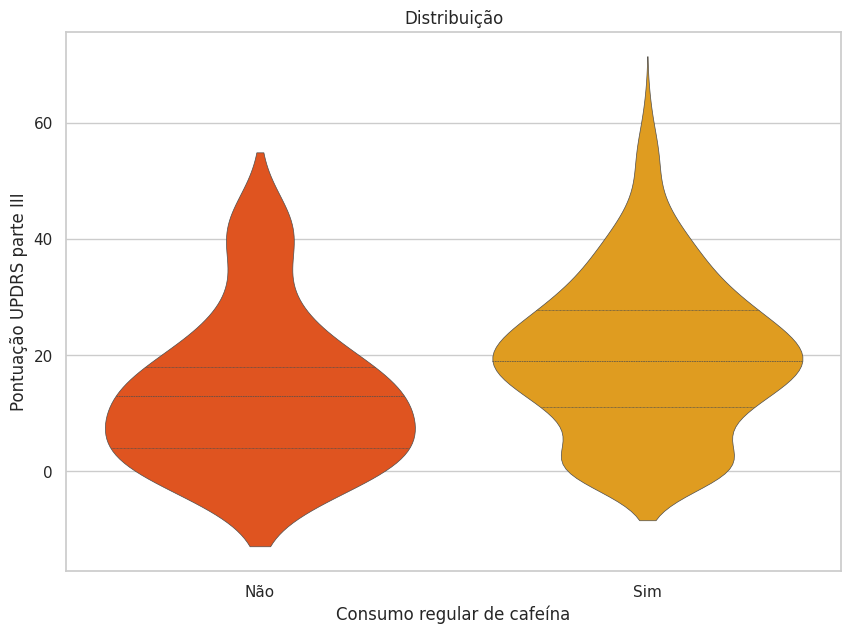

In [45]:
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(10, 7))
sns.violinplot(
    x='caff_drinks_ever_used_regularly',
    y='mds_updrs_part_iii_summary_score',
    data=cafe_binario,
    hue = 'caff_drinks_ever_used_regularly',
    palette=['#FF4500', '#FFA500'],
    linewidth=0.5,
    inner="quart",
    scale="count",
    legend=False
)

plt.xticks([0, 1], ['Não', 'Sim'], fontsize=11)
plt.xlabel("Consumo regular de cafeína")
plt.ylabel("Pontuação UPDRS parte III")
plt.title("Distribuição")
plt.show()


-----------------------------------------------------------------------------------------------------------
###### GRÁFICOS CERVEJA ######

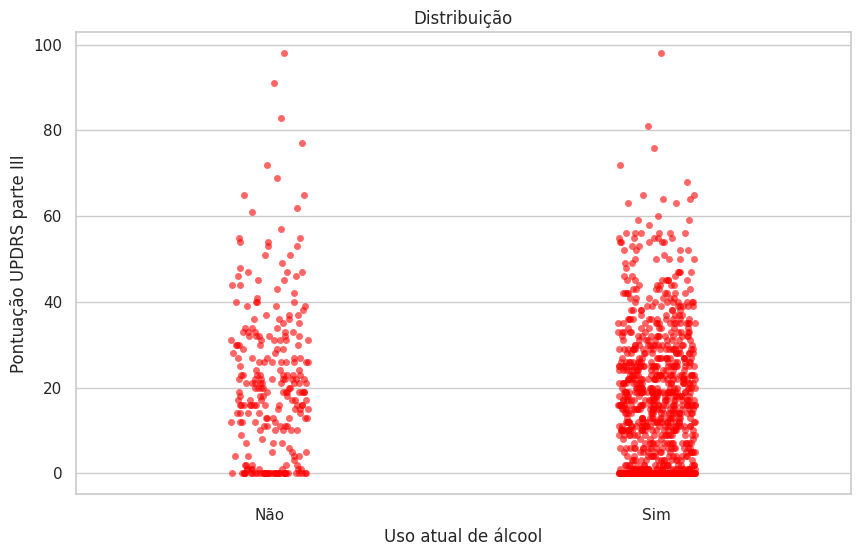

In [46]:

plt.figure(figsize=(10, 6))
sns.stripplot(x='alcohol_current_use', y='mds_updrs_part_iii_summary_score', data=cerveja_binario, jitter=True, alpha=0.6, color='red')

plt.xticks([0, 1], ['Não', 'Sim'], fontsize=11)
plt.xlabel("Uso atual de álcool")
plt.ylabel("Pontuação UPDRS parte III")
plt.title("Distribuição")
plt.show()


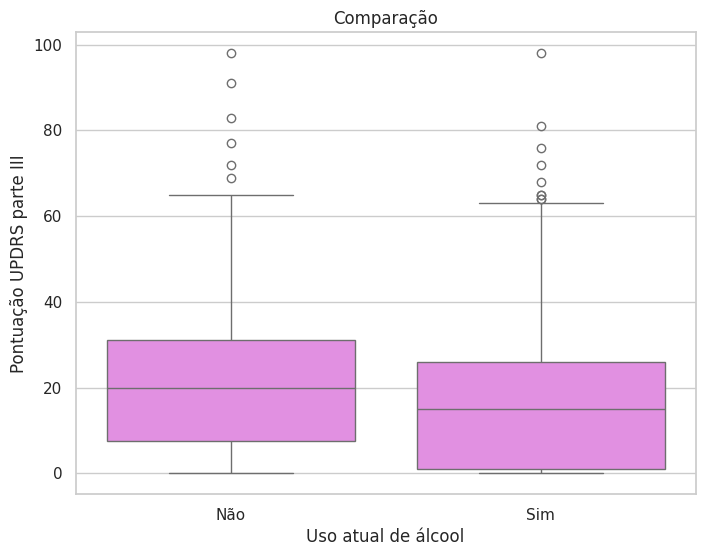

In [47]:
# Boxplot para comparar as pontuações entre os grupos

plt.figure(figsize=(8, 6))
sns.boxplot(x='alcohol_current_use', y='mds_updrs_part_iii_summary_score', data=cerveja_binario, color = 'violet')

plt.xticks([0, 1], ['Não', 'Sim'], fontsize=11)
plt.xlabel("Uso atual de álcool")
plt.ylabel("Pontuação UPDRS parte III")
plt.title("Comparação")
plt.show()

/tmp/ipykernel_74/1668290889.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(


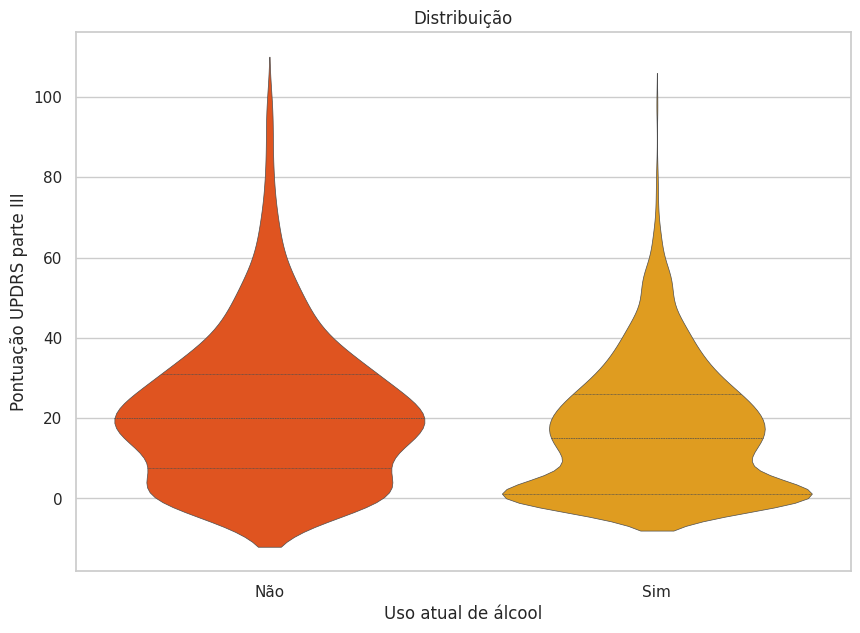

In [48]:
# Plot violino para observar a distribuição

sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(10, 7))
sns.violinplot(
    x='alcohol_current_use',
    y='mds_updrs_part_iii_summary_score',
    data=cerveja_binario,
    hue = 'alcohol_current_use',
    palette=['#FF4500', '#FFA500'],
    linewidth=0.5,
    inner="quart",
    scale="count",
    legend=False
)

plt.xticks([0, 1], ['Não', 'Sim'], fontsize=11)
plt.xlabel("Uso atual de álcool")
plt.ylabel("Pontuação UPDRS parte III")
plt.title("Distribuição")
plt.show()


In [49]:
## DADOS DEMOGRÁFICOS

demografico = pd.read_csv(f'{WORK_DIR}/Demographics.csv')

In [50]:
demografico

,participant_id,GUID,visit_name,visit_month,age_at_baseline,sex,ethnicity,race,education_level_years
0,BF-1001,PDNW781VHY,M0,0,55,Male,Not Hispanic or Latino,White,12-16 years
1,BF-1002,PDCB969UGG,M0,0,66,Female,Not Hispanic or Latino,White,12-16 years
2,BF-1003,PDLW805AHT,M0,0,61,Male,Not Hispanic or Latino,White,12-16 years
3,BF-1004,PDKW284DYW,M0,0,62,Male,Not Hispanic or Latino,White,12-16 years
4,BF-1005,PDTM274KX6,M0,0,61,Female,Not Hispanic or Latino,White,12-16 years
...,...,...,...,...,...,...,...,...,...
10903,PM-UM_HCTIX,NaN,M0,0,67,Male,Not Hispanic or Latino,White,Unknown
10904,PM-UM_HCTNJ,NaN,M0,0,76,Male,Not Hispanic or Latino,White,Unknown
10905,PM-UM_HCTTO,NaN,M0,0,83,Female,Not Hispanic or Latino,White,Unknown
10906,PM-UM_HCTWJ,NaN,M0,0,64,Male,Hispanic or Latino,White,Unknown


In [51]:
## CONCATENAR DATAFRAMES

cafe_demo = pd.merge(cafe_binario, demografico, on = 'participant_id')
cerveja_demo = pd.merge(cerveja_binario, demografico, on = 'participant_id')

In [52]:
cerveja_demo

,participant_id,visit_name_x,alcohol_ever_used,alcohol_current_use,mds_updrs_part_iii_summary_score,mds_updrs_part_iv_summary_score,GUID,visit_name_y,visit_month,age_at_baseline,sex,ethnicity,race,education_level_years
0,BF-1085,M0,1,1.0,14.0,2.0,PDKH960RVF,M0,0,66,Male,Not Hispanic or Latino,White,12-16 years
1,BF-1121,M0,1,0.0,24.0,4.0,PDFK952LNH,M0,0,72,Female,Not Hispanic or Latino,White,Greater than 16 years
2,BF-1123,M0,1,0.0,53.0,7.0,PDPW971YLK,M0,0,74,Male,Not Hispanic or Latino,White,12-16 years
3,BF-1124,M0,1,1.0,44.0,9.0,PDFJ573KXY,M0,0,63,Female,Not Hispanic or Latino,White,12-16 years
4,BF-1133,M0,1,0.0,33.0,4.0,PD_INVTG922XML,M0,0,77,Male,Not Hispanic or Latino,White,12-16 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,PP-75524,M0,1,0.0,11.0,0.0,NIHLG772GRYC5,SC,-1,54,Male,Not Hispanic or Latino,White,12-16 years
1225,PP-92834,M18,1,0.0,0.0,0.0,NaN,SC,-1,66,Male,Not Hispanic or Latino,White,12-16 years
1226,SU-32881,M0,1,1.0,19.0,0.0,PDHB568RCB,M0,0,63,Female,Not Hispanic or Latino,White,12-16 years
1227,SU-33182,M0,1,1.0,18.0,0.0,PDHJ424BPR,M0,0,58,Female,Unknown,White,12-16 years


In [53]:
# Limpar DataFrames

cafe_demo_sum = cafe_demo[['participant_id', 'caff_drinks_ever_used_regularly', 'age_at_baseline', 'sex', 'race', 'mds_updrs_part_iii_summary_score', 'mds_updrs_part_iv_summary_score']]
cerveja_demo_sum = cerveja_demo[['participant_id', 'alcohol_current_use', 'age_at_baseline', 'sex', 'race', 'mds_updrs_part_iii_summary_score', 'mds_updrs_part_iv_summary_score']]

In [54]:
# Binarizar sexo

cafe_demo_sum.loc[:, 'sex'] = cafe_demo_sum['sex'].map({'Female': 0, 'Male': 1})
cerveja_demo_sum.loc[:, 'sex'] = cerveja_demo_sum['sex'].map({'Female': 0, 'Male': 1})

In [55]:
# RETIRAR DUPLICADAS

cafe_demo_sum = cafe_demo_sum.dropna(subset=['caff_drinks_ever_used_regularly', 'age_at_baseline', 'sex', 'mds_updrs_part_iii_summary_score'])

print(cafe_demo_sum.dtypes)

participant_id                       object
caff_drinks_ever_used_regularly       int64
age_at_baseline                       int64
sex                                  object
race                                 object
mds_updrs_part_iii_summary_score    float64
mds_updrs_part_iv_summary_score     float64
dtype: object


In [56]:
cafe_demo_sum

,participant_id,caff_drinks_ever_used_regularly,age_at_baseline,sex,race,mds_updrs_part_iii_summary_score,mds_updrs_part_iv_summary_score
0,PD-PDAJ440URR,1,55,0,White,0.0,0.0
1,PD-PDBK615WC6,1,45,1,White,0.0,0.0
2,PD-PDBY238FWE,1,45,0,White,0.0,0.0
3,PD-PDCF053TPC,1,23,0,White,0.0,0.0
4,PD-PDCR944LPD,0,51,1,White,4.0,0.0
...,...,...,...,...,...,...,...
334,PP-90456,0,82,1,White,9.0,0.0
335,PP-92834,1,66,1,White,0.0,0.0
336,PP-70188,1,67,1,White,20.0,1.0
337,PP-74199,1,61,1,White,24.0,8.0


In [57]:
cafe_demo_sum['caff_drinks_ever_used_regularly'] = pd.to_numeric(cafe_demo_sum['caff_drinks_ever_used_regularly'], errors='coerce')
cafe_demo_sum['age_at_baseline'] = pd.to_numeric(cafe_demo_sum['age_at_baseline'], errors='coerce')
cafe_demo_sum['sex'] = pd.to_numeric(cafe_demo_sum['sex'], errors='coerce')
cafe_demo_sum['mds_updrs_part_iii_summary_score'] = pd.to_numeric(cafe_demo_sum['mds_updrs_part_iii_summary_score'], errors='coerce')

print(cafe_demo_sum.dtypes)

participant_id                       object
caff_drinks_ever_used_regularly       int64
age_at_baseline                       int64
sex                                   int64
race                                 object
mds_updrs_part_iii_summary_score    float64
mds_updrs_part_iv_summary_score     float64
dtype: object


In [62]:
import statsmodels.api as sm


# Defina as variáveis independentes e dependente
X3 = cafe_demo_sum[['caff_drinks_ever_used_regularly', 'sex', 'age_at_baseline']]
Y3 = cafe_demo_sum['mds_updrs_part_iii_summary_score']

# Verifique se X e y têm dados
if X3.empty or Y3.empty:
    print("Erro: Os dados estão vazios ou foram completamente filtrados.")
else:
    # Adicione uma constante para o intercepto
    X3 = sm.add_constant(X3)

    # Construa e ajuste o modelo de regressão
    modelo = sm.OLS(Y3, X3).fit()

    # Exiba o resumo do modelo
    print(modelo.summary())

                                   OLS Regression Results                                   
Dep. Variable:     mds_updrs_part_iii_summary_score   R-squared:                       0.074
Model:                                          OLS   Adj. R-squared:                  0.066
Method:                               Least Squares   F-statistic:                     8.914
Date:                              Tue, 12 Nov 2024   Prob (F-statistic):           1.07e-05
Time:                                      12:18:56   Log-Likelihood:                -1344.5
No. Observations:                               339   AIC:                             2697.
Df Residuals:                                   335   BIC:                             2712.
Df Model:                                         3                                         
Covariance Type:                          nonrobust                                         
                                      coef    std err          t      